# Dataset

In [1]:
import cv2
import numpy as np
import torch
from PIL import Image
from torchvision import transforms

class HistogramEqualization:
    """Aplica ecualización de histograma para ajuste de contraste"""
    def __call__(self, img):
        # Convertir PIL Image a numpy array
        img_np = np.array(img)
        
        # Aplicar ecualización de histograma por canal
        if len(img_np.shape) == 3:  # Imagen RGB
            img_eq = np.zeros_like(img_np)
            for i in range(3):
                img_eq[:,:,i] = cv2.equalizeHist(img_np[:,:,i])
        else:  # Imagen en escala de grises
            img_eq = cv2.equalizeHist(img_np)
            
        # Convertir de nuevo a PIL Image
        return Image.fromarray(img_eq)

class BilateralFilter:
    """Aplica filtrado bilateral para suavizado preservando bordes"""
    def __init__(self, d=9, sigma_color=75, sigma_space=75):
        self.d = d  # Diámetro de cada vecindario de píxeles
        self.sigma_color = sigma_color  # Filtro sigma en el espacio de color
        self.sigma_space = sigma_space  # Filtro sigma en el espacio de coordenadas
    
    def __call__(self, img):
        # Convertir PIL Image a numpy array
        img_np = np.array(img)
        
        # Aplicar filtro bilateral
        img_filtered = cv2.bilateralFilter(
            img_np, self.d, self.sigma_color, self.sigma_space)
            
        # Convertir de nuevo a PIL Image
        return Image.fromarray(img_filtered)


In [2]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt

class DatasetExperiment1(Dataset):
    def __init__(self, mode='train', batch_size=32,grey = False, local = False, path = ''):
        """
        Args:
            mode (str): 'train', 'val' o 'test'.
            transform: Transformaciones de torchvision a aplicar a las imágenes.
        """
        assert mode in ['train', 'val', 'test'], "Mode must be 'train', 'val', or 'test'"
        if local:
            print("LOCAL MODE ENABLED")
        self.grey = grey
        # Transformaciones del paper
        # Histogram equalization for contrast adjustment
        # and bilateral filtering for smoothness
        self.transform =  transforms.Compose([
            transforms.Resize((224, 224)),
            HistogramEqualization(),
            BilateralFilter(d=9, sigma_color=75, sigma_space=75),
            transforms.ToTensor(),
        ])
        self.data_path = os.path.join(path, mode)
        self.classes = sorted(os.listdir(self.data_path))  # Lista de clases
        self.data = []
        self.batch_size = batch_size
        # Cargar imágenes con sus etiquetas
        

        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(self.data_path, class_name)
            i = 0
            for img_name in os.listdir(class_path):
                if local and i >= 3:
                    break
                img_path = os.path.join(class_path, img_name)
                self.data.append((img_path, label))
                i += 1
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        if not self.grey:
            image = Image.open(img_path).convert('RGB')
        else:
            image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
    def get_dataloader(self, shuffle=True):       
        return DataLoader(self, batch_size=self.batch_size, shuffle=shuffle)
    def show_image(self, idx, transformed=True, figsize=(10, 8)):
        """
        Muestra una imagen del dataset con su etiqueta
        
        Args:
            idx (int): Índice de la imagen a mostrar
            transformed (bool): Si es True, muestra la imagen transformada. 
                               Si es False, muestra la imagen original.
            figsize (tuple): Tamaño de la figura (ancho, alto)
        """
        if idx >= len(self):
            print(f"Índice {idx} fuera de rango. El dataset tiene {len(self)} elementos.")
            return
        
        img_path, label = self.data[idx]
        class_name = self.classes[label]
        
        plt.figure(figsize=figsize)
        
        # Mostrar imagen original
        orig_img = Image.open(img_path).convert('RGB')
        plt.subplot(1, 2, 1)
        plt.imshow(orig_img)
        plt.title(f"Original: Clase {class_name} (label {label})")
        plt.axis('off')
        
        # Mostrar imagen transformada si se solicita
        if transformed:
            trans_img = self.transform(orig_img)
            # Convertir tensor a numpy para visualización
            if isinstance(trans_img, torch.Tensor):
                trans_img = trans_img.permute(1, 2, 0).numpy()  # Cambiar de CxHxW a HxWxC
                # Normalizar valores para visualización
                trans_img = np.clip(trans_img, 0, 1)
            
            plt.subplot(1, 2, 2)
            plt.imshow(trans_img)
            plt.title("Con transformaciones aplicadas")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Imprimir información adicional
        print(f"Ruta de la imagen: {img_path}")
        print(f"Clase: {class_name} (label {label})")
        print(f"Resolución original: {orig_img.size}")
        if transformed and isinstance(trans_img, np.ndarray):
            print(f"Resolución después de transformaciones: {trans_img.shape[:2]}")




# Train config 1

The hyperparameters of the proposed ensemble model were
tuned by the trial-and-error method. 
L2 regularization, 
batch normalization, 
dropout rate

The Adam optimizer
Epochs = 150. 
The learning rate scheduler and ReduceLROnPlateau were used for handling
the learning rate with an initial value of 0.001. The loss
function used for the model was categorical cross-entropy

## Trainer

In [3]:
!pip install -q lightning
import lightning.pytorch as pl
import torch
import torch.nn as nn
import torchmetrics as tm
from torchmetrics.classification import MulticlassConfusionMatrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class Classification(pl.LightningModule):
    """
    Trainer para entrenar un modelo de clasificación multiclase
    y de dimension 1 con valores [0, num_classes]
    """
    def __init__(self, model, device, L1=0.001, L2=0.001, lr=0.001, patience=5, factor=0.1, betas=(0.9, 0.999)):
        super().__init__()
        self.save_hyperparameters(ignore=("model",))

        self.model = model

        self.loss_fn = nn.CrossEntropyLoss()
        self.L1 = L1
        self.L2 = L2
        self.learning_rate = lr
        self.patience = patience
        self.factor = factor
        self.betas = betas

        self.num_classes = 5
        self.confusion_matrix = MulticlassConfusionMatrix(num_classes=5).to(device)
        self.auc_metric = tm.AUROC(num_classes=5, task="multiclass").to(device)  # Definir métrica AUROC para clasificación multiclase

    def forward(self, x):
        return self.model(x)

    def training_step(self, x, y):
        y = y
        y_hat = self.model(x)
        y_oh = self.transform_classes(y)
        loss = self.loss_fn(y_hat, y_oh)
        
        # Regularización L1
        L1_reg = torch.tensor(0., requires_grad=True)
        for param in self.model.parameters():
            L1_reg = L1_reg + torch.sum(torch.abs(param))
        
        # Regularización L2
        L2_reg = torch.tensor(0., requires_grad=True)
        for param in self.model.parameters():
            L2_reg = L2_reg + torch.sum(param ** 2)
        
        # Añadir regularización a la pérdida
        prediction_loss = loss
        loss = loss + self.L1 * L1_reg + self.L2 * L2_reg
        # Obtener la clase predicha
        y_pred = torch.argmax(y_hat, dim=1)
        # Calcular métricas
        loss.backward()
        self.confusion_matrix.update(y_pred, y)
        self.auc_metric.update(y_hat, y)

        precision, recall, f1_score, ACC, AUC, specificity = self.calculate_metrics_from_confusion_matrix()

        return {"loss": prediction_loss, "real_loss": loss, "ACC": ACC, "recall": recall, "precision": precision, "f1_score": f1_score, "AUC": AUC, "specificity": specificity}

    def validation_step(self, x, y):
        y = y
        y_hat = self.model(x)
        y_oh = self.transform_classes(y)
        loss = self.loss_fn(y_hat, y_oh)
        # Obtener la clase predicha
        y_pred = torch.argmax(y_hat, dim=1)
        # Calcular métricas
        self.confusion_matrix.update(y_pred, y)
        self.auc_metric.update(y_hat, y)

        precision, recall, f1_score, ACC, AUC, specificity = self.calculate_metrics_from_confusion_matrix()
        return {"loss": loss, "ACC": ACC, "precision" : precision, "recall": recall, "f1_score" : f1_score, "AUC": AUC, "specificity": specificity}

    def transform_classes(self, y):
        # Convertir las clases a un formato de one-hot encoding
        return torch.nn.functional.one_hot(y.to(torch.int64), num_classes=5).to(float).squeeze()
    def restart_epoch(self, plot = False):
        if plot:
            self.plot()
        self.confusion_matrix.reset()
        self.auc_metric.reset()
    def calculate_metrics_from_confusion_matrix(self):
        # Obtener la matriz de confusión (suponiendo que es un tensor de torch)
        cm = self.confusion_matrix.compute()
        total_samples = cm.sum()
        
        # Verdaderos positivos por clase (diagonal de la matriz)
        true_positives = torch.diag(cm)
        
        # Predicciones totales por clase (sumar columnas)
        predicted_positives = cm.sum(dim=0)
        
        # Ejemplos reales por clase (sumar filas)
        actual_positives = cm.sum(dim=1)
        
        # Calcular falsos positivos y falsos negativos por clase
        false_positives = predicted_positives - true_positives
        false_negatives = actual_positives - true_positives
        
        # Calcular verdaderos negativos por clase
        true_negatives = total_samples - (actual_positives + predicted_positives - true_positives)
        
        # Calcular métricas por clase con robustez para evitar división por cero
        precision_per_class = true_positives / (predicted_positives + 1e-8)
        recall_per_class = true_positives / (actual_positives + 1e-8)
        specificity_per_class = true_negatives / (true_negatives + false_positives + 1e-8)
        f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class + 1e-8)
        
        # Promediar las métricas por clase
        precision = precision_per_class.mean()
        recall = recall_per_class.mean()
        specificity = specificity_per_class.mean()
        f1 = f1_per_class.mean()
        
        # Calcular Accuracy (exactitud)
        ACC = true_positives.sum() / total_samples
        
        # Calcular el AUC (suponiendo que self.auc_metric ya está correctamente definido)
        AUC = self.auc_metric.compute()
        
        return precision, recall, f1, ACC, AUC, specificity


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(),
                                     lr=self.learning_rate,
                                     betas=self.betas)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                               factor=self.factor,
                                                               patience=self.patience)
        return optimizer, scheduler
    def plot(self, epoch=0):
        # Computa la matriz de confusión y las métricas por clase
        cm = self.confusion_matrix.compute().cpu().numpy()
        support = cm.sum(axis=1)
        precision_per_class = np.diag(cm) / (cm.sum(axis=0) + 1e-8)
        recall_per_class = np.diag(cm) / (cm.sum(axis=1) + 1e-8)
        f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class + 1e-8)
        
        # Cálculo de especificidad por clase
        FP = cm.sum(axis=0) - np.diag(cm)
        FN = cm.sum(axis=1) - np.diag(cm)
        TN = cm.sum() - (FP + FN + np.diag(cm))
        specificity_per_class = TN / (TN + FP + 1e-8)
        
        accuracy = np.diag(cm).sum() / cm.sum()

        # Crea dos subplots: uno para la matriz de confusión y otro para la tabla de métricas
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))

        # Subplot 1: Matriz de confusión con heatmap
        sns.heatmap(cm, annot=True, fmt="d", ax=axs[0], cmap="Blues")
        axs[0].set_title("Matriz de Confusión epoch " + str(epoch))
        axs[0].set_xlabel("Predicción")
        axs[0].set_ylabel("Real")

        # Subplot 2: Tabla de métricas por clase
        table_data = []
        for i in range(self.num_classes):
            table_data.append([f"Clase {i}",
                            f"{precision_per_class[i]:.2f}",
                            f"{recall_per_class[i]:.2f}",
                            f"{f1_per_class[i]:.2f}",
                            f"{specificity_per_class[i]:.2f}",
                            int(support[i])])
        axs[1].axis('tight')
        axs[1].axis('off')
        table = axs[1].table(cellText=table_data,
                            colLabels=["Clase", "Precision", "Sensivity/Recall", "F1", "Specificity", "Support"],
                            cellLoc="center", loc="center")
        axs[1].set_title(f"Metrics por clase\nAccuracy General: {accuracy:.2f}", pad=20)

## Model

In [4]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision.models as models

class ResNet50Model(nn.Module):
    """
    Modelo basado en ResNet50 para la clasificación de radiografías.
    Permite personalización en el número de clases y si se usa transfer learning.
    """
    def __init__(self, num_classes=5, pretrained=True, grey = False, dropout_rate=0.3):
        """
        Inicializa el modelo ResNet50.
        
        Args:
            num_classes (int): Número de clases para la clasificación (default: 5)
            pretrained (bool): Si se deben usar pesos preentrenados en ImageNet (default: True)
            freeze_backbone (bool): Si se deben congelar las capas de la red base (default: False)
            dropout_rate (float): Tasa de dropout aplicada antes de la capa de clasificación (default: 0.3)
        """
        super(ResNet50Model, self).__init__()
        
        # Cargar el modelo base ResNet50
        self.model = models.resnet50(weights='IMAGENET1K_V2' if pretrained else None)
        
        # Nombre del modelo para identificación
        self.name = "ResNet50"
        
        
        # Reemplazar la capa de clasificación final
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )
        if grey:
            # Guardamos la capa original
            original_conv = self.model.conv1
            # Creamos una nueva capa que acepte 1 canal de entrada
            self.model.conv1 = nn.Conv2d(
                in_channels=1, 
                out_channels=original_conv.out_channels, 
                kernel_size=original_conv.kernel_size, 
                stride=original_conv.stride, 
                padding=original_conv.padding, 
                bias=False
            )
            if pretrained:
                # Inicializamos los pesos promediando los de los 3 canales originales
                self.model.conv1.weight.data = original_conv.weight.data.mean(dim=1, keepdim=True)
        
    
    def forward(self, x):
        """
        Propagación hacia adelante a través del modelo.
        
        Args:
            x: Tensor de entrada con forma [batch_size, channels, height, width]
            
        Returns:
            Tensor con las predicciones de clase [batch_size, num_classes]
        """
        return self.model(x)
    
    def get_features(self, x):
        """
        Obtiene los features del modelo antes de la capa de clasificación.
        Útil para análisis de características o transferencia de estilo.
        
        Args:
            x: Tensor de entrada con forma [batch_size, channels, height, width]
            
        Returns:
            Tensor de características [batch_size, 2048]
        """
        # Extrae todas las capas excepto la final
        modules = list(self.model.children())[:-1]
        feature_extractor = nn.Sequential(*modules)
        
        # Obtiene los features y los aplana
        features = feature_extractor(x)
        features = features.view(features.size(0), -1)
        
        return features


## Train function

In [5]:
import torch
from tqdm import tqdm
from wandb import wandb

def create_tqdm_bar(iterable, desc, mode):
    return tqdm(enumerate(iterable),total=len(iterable), ncols=200, desc=desc)

def train_model(model, trainer, train_dataset, val_dataset, epochs=5, transform=None, device='cuda', save_model = "", name="Test", wdb=True, local=False, project="oai-knee-cartilage-segmentation"):
    if wdb:
        if wandb.run is not None:
            wandb.finish()
        wandb.init(
            project=project,
            name=name,
            # track hyperparameters and run metadata
            config={
                "model": model.name,
                "Batch_size": train_dataset.batch_size,
                "learning_rate": trainer.learning_rate,
                "L1": trainer.L1,
                "L2": trainer.L2,
                "patience": trainer.patience,
                "factor": trainer.factor,
                "betas": trainer.betas,
                "epochs": epochs,
            }
        )
    train_loader = train_dataset.get_dataloader(shuffle=True)
    val_loader = val_dataset.get_dataloader(shuffle=True)
    model.to(device)
    train(model, train_loader, val_loader, trainer, epochs, device, wdb, local = local, save_model = save_model)
    

def train(model, train_loader, val_loader, trainer, epochs, device, wdb, local = False, save_model = ""):
    """
    train the given model
    """
    optimizer, scheduler = trainer.configure_optimizers()
    best_model = None
    best_loss = float('inf')
    for epoch in range(epochs):        
        training_loss = []
        validation_loss = []

        training_loss_num = 0
        complete_loss_num = 0
        validation_loss_num = 0

        # use training data
        model.train()

        training_loop = create_tqdm_bar(train_loader, desc=f'Training Epoch [{epoch + 1}/{epochs}]', mode='train')
        for train_iteration, batch in training_loop:
            batch = batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad()
            res = trainer.training_step(batch[0], batch[1])
            optimizer.step()

            training_loss.append(res['loss'].item())
            training_loss_num += res['loss'].item()
            complete_loss_num += res['real_loss'].item()
            # Update the progress bar.
            training_loop.set_postfix(train_loss="{:.4f}".format(training_loss_num / (train_iteration + 1)),
                                      complete_loss="{:.4f}".format(complete_loss_num / (train_iteration + 1)),
                                      acc=res['ACC'].item(),
                                      AUC=res['AUC'].item(),
                                      sensivity=res['recall'].item(),
                                      specificity=res['specificity'].item())
            if wdb:
                
                wandb.log({"train_loss": training_loss_num / (train_iteration + 1),
                           "complete_loss": complete_loss_num / (train_iteration + 1),
                        "train_acc": res['ACC'],
                        "train_recall": res['recall'].item(),
                        "train_precision": res['precision'].item(),
                        "train_specifity": res['specificity'].item(),
                        "train_f1_score": res['f1_score'].item(),
                        "train_AUC": res['AUC'],
                        "epoch": epoch,
                        "learning_rate": optimizer.param_groups[0]['lr']})
        trainer.restart_epoch(plot=False)
        # use validation data
        if local:
            continue
        model.eval()
        val_loop = create_tqdm_bar(val_loader, desc=f'Validation Epoch [{epoch + 1}/{epochs}]', mode='val')
        with torch.no_grad():
            for val_iteration, batch in val_loop:
                batch = batch[0].to(device), batch[1].to(device)
                res = trainer.validation_step(batch[0], batch[1])  
                validation_loss.append(res['loss'].item())
                validation_loss_num += res['loss'].item()
                val_loop.set_postfix(val_loss = "{:.8f}".format(validation_loss_num / (val_iteration + 1)),
                                      acc=res['ACC'].item(),
                                      AUC=res['AUC'].item(),
                                      specificity=res['specificity'].item())
                                      
        if wdb:
            wandb.log({"val_loss": validation_loss_num / (val_iteration + 1),
                    "val_acc": res['ACC'],
                    "val_recall": res['recall'].item(),
                    "val_precision": res['precision'].item(),
                    "val_specificity": res['specificity'].item(),
                    "val_f1_score": res['f1_score'].item(),
                    "val_AUC": res['AUC'],
                    "epoch": epoch,
                    "learning_rate": optimizer.param_groups[0]['lr']})
        if validation_loss_num < best_loss:
            best_loss = validation_loss_num
            if save_model != "":
                torch.save(model.state_dict(), f"best_model_{model.__class__.__name__}_{save_model}_epoch_{epoch}.pt")
        scheduler.step(validation_loss_num)
        trainer.restart_epoch(plot=False)
    
    test_model(model, val_loader, trainer, device, wdb)

def test_model(model, test_loader, trainer, device, wdb=False):
    """
    Test the given model
    """
    model.eval()
    model.to(device)

    epoch_loss = 0.0
    avg_loss = 0.0
    trainer.restart_epoch(plot = False)
    for batch in test_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        
        labels = labels.to(device)

        with torch.no_grad():
            res = trainer.validation_step(inputs, labels)
            # Extraer valores escalares
            loss = res['loss']
            
        loss_value = loss.item()
        # Calcular promedios
        epoch_loss += loss_value

    ACC_value = res['ACC']
    recall_value = res['recall'].item()
    precision_value = res['precision'].item()
    f1_score_value = res['f1_score'].item()
    AUC_value = res['AUC']
    avg_loss = epoch_loss / len(test_loader)
    if wdb:
        wandb.log({"test_loss": avg_loss, "test_acc": ACC_value.item(),
                "test_recall": recall_value, "test_precision": precision_value,
                "test_f1_score": f1_score_value, "test_AUC" : AUC_value})
    
    print(f"Test model {model.__class__.__name__} - Loss: {avg_loss:.2f}, ACC: {ACC_value:.2f}, AUC: {AUC_value:.2f}, Sensivility: {recall_value:.2f}, Specificity: {precision_value:.2f}")

    trainer.restart_epoch(plot = True)

In [6]:
import os
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
BATCH_SIZE = 64
LEARNING_RATE = 0.001
FACTOR = 0.1
L1 = 0.00
L2 = 0.00005
PATIENCE = 7
BETAS=(0.9, 0.999)
GREY = True
DATASET_PATH = '/kaggle/input/augmented-oai-bright/augmented_oai_bright'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = DatasetExperiment1('train', batch_size=BATCH_SIZE, local=False,grey=True, path = DATASET_PATH)
val_dataset = DatasetExperiment1('val', batch_size=BATCH_SIZE, local=False, grey=True, path = DATASET_PATH)
model = ResNet50Model(num_classes=len(train_dataset.classes), dropout_rate=0.5,grey = True, pretrained = False)
trainer = Classification(model, device, L1=L1, L2=L2, lr=LEARNING_RATE, patience=PATIENCE, factor=FACTOR, betas=BETAS)



In [7]:
wandb.login(key="254f72e7bdeec44797ba1b2a91ebbc63900b89f4")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: chermar (chermar-universitat-polit-cnica-de-val-ncia). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250307_213930-clxpn0ia
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run -Bright
wandb: ⭐️ View project at https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oai-knee-cartilage-segmentation
wandb: 🚀 View run at https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oai-knee-cartilage-segmentation/runs/clxpn0ia
Training Epoch [2/30]:   0%|                                                                                                                                                    | 0/434 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
Validation Epoch [30/30]: 100%|█████████████████████████████████████████████████████████

Test model ResNet50Model - Loss: 1.56, ACC: 0.55, AUC: 0.85, Sensivility: 0.50, Specificity: 0.65


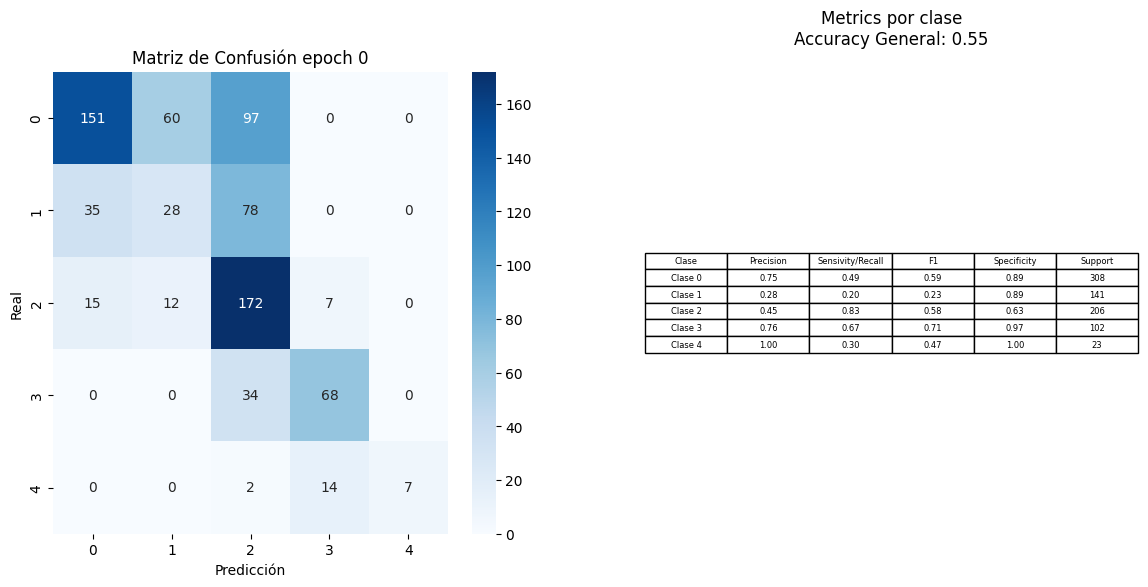

In [8]:
# Primera prueba para ver el entrenamiento
# He probado antes en local para ver como alcanzaba un 100% de acc y 0.001 de loss con pocos datos
train_model(model, trainer, train_dataset, val_dataset, epochs=30, device=device, save_model = "experimento1.2", name="-Bright", wdb=True, local=False)